#### Import Libraries

In [1]:
import os 
import sys
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'ConvLSTM_PyTorch_master'))
import numpy as np 
import pandas as pd
import xarray as xr 
import matplotlib.pyplot as plt 
import seaborn as sns
import cartopy.crs as ccrs
from tqdm import tqdm

import torch
from torch import nn

from net_params_auto import convlstm_encoder_params, convlstm_decoder_params
from encoder import Encoder
from decoder import Decoder
from model import ED

#from captum.attr import (Saliency, InputXGradient, IntegratedGradients, DeepLift, NoiseTunnel)

#### Uplaod Model

In [5]:
frames_predict = 12
num_layers = 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

model_path = os.path.join(os.getcwd(), '..', '..', 'experiments', 'convlstm_mae_4_PerPixel_mean-std_hourly_100_epochs_FP12', 'models', 'ckpt')

cuda:0


In [6]:
def load_model():

    encoder_params = convlstm_encoder_params(num_layers, input_len=frames_predict, device=device)
    decoder_params = convlstm_decoder_params(num_layers, output_len=frames_predict, device=device)

    encoder = Encoder(encoder_params[0], encoder_params[1]).to(device)
    decoder = Decoder(decoder_params[0], decoder_params[1], num_layers).to(device)
    
    net = ED(encoder, decoder)

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    
    net.to(device)

    torch.cuda.empty_cache()

    # Loading model
    model_info = torch.load(os.path.join(model_path, 'checkpoint_50.pth.tar'), map_location=device)
        
    net.load_state_dict(model_info['state_dict'])

    return net 

In [7]:
net = load_model().eval()
print('ConvLSTM Model loaded successfully')

ConvLSTM Model loaded successfully


#### Reception Field Function

In [ ]:
    # Define the center of the rectangle in the input
    center_x, center_y = input_size[1] // 2, input_size[2] // 2
    rect_height, rect_width = rect_size

    # Activate a rectangle centered around (center_x, center_y)
    start_x = max(center_x - rect_height // 2, 0)
    end_x = min(center_x + rect_height // 2, input_size[1])
    start_y = max(center_y - rect_width // 2, 0)
    end_y = min(center_y + rect_width // 2, input_size[2])

    # Activate the rectangular region
    input_tensor[:, :, start_x:end_x, start_y:end_y] = 1.0  # Activate a rectangle region

    # Forward pass
    output = model(input_tensor.unsqueeze(2)).squeeze(2)  # Output shape: (batch_size, 12, 144, 144)
    
    # Compute the difference from the zero input
    zero_output = model(torch.zeros_like(input_tensor).unsqueeze(2)).squeeze(2)
    delta_output = (output - zero_output).abs()  # Check which pixels changed

    # Compute receptive field: where the change is above the threshold
    receptive_field = (delta_output > threshold).float().sum(dim=0)  # Sum across batch and time
    
    return receptive_field


In [83]:
def compute_receptive_field(model, input_size=(1, 12, 144, 144), input_frame=-1, flag_value=1.0, rect_size=(3, 3), threshold=1e-5):
    """
    Compute the receptive field of the ConvLSTM model by activating a rectangle region.

    Parameters:
    - model: PreTrained PyTorch ConvLSTM model.
    - input_size: Shape of the input (frames, height, width).
    - rect_size: Tuple (rect_height, rect_width) for the size of the rectangle to activate.
    - threshold: Minimum absolute value to consider an activation as affected.

    Returns:
    - receptive_field: Tensor (height, width) indicating affected regions.
    """

    model.eval()
    # Create an empty input tensor
    input_tensor = torch.zeros((input_size), dtype=torch.float32).to(device)

    # Forward pass for a input of zeros.
    output_zeros = model(input_tensor.unsqueeze(2)).squeeze(2) 

    # Define the center of the rectangle in the input
    center_x, center_y = input_size[2] // 2, input_size[3] // 2
    rect_height, rect_width = rect_size

    # Activate a rectangle centered around (center_x, center_y)
    start_x = max(center_x - rect_height // 2, 0)
    end_x = min(center_x + rect_height // 2, input_size[2])
    start_y = max(center_y - rect_width // 2, 0)
    end_y = min(center_y + rect_width // 2, input_size[3])

    # Activate the rectangular region
    if input_frame == -1:
        input_tensor[:, :, start_x:end_x, start_y:end_y] = flag_value  # Activate a rectangle region
    else:
        input_tensor[:, 11+input_frame, start_x:end_x, start_y:end_y] = flag_value  # Activate a rectangle region

    # Forward pass for a input with a region activated 
    output = model(input_tensor.unsqueeze(2)).squeeze(2)  # Output shape: (batch_size, 12, 144, 144)

    # Compute the difference from the zero input
    delta_output = (output - output_zeros).abs()  # Check which pixels changed
    
    # Compute receptive field: where the change is above the threshold
    receptive_field = (delta_output > threshold).float().sum(dim=0)  # Sum across batch
    
    return input_tensor[0], receptive_field

In [95]:
inputs, receptive_field = compute_receptive_field(model=net, rect_size=(5, 5), input_frame=0)

#### Send outputs to CPU

In [96]:
inputs = inputs.detach().cpu().numpy()
receptive_field = receptive_field.detach().cpu().numpy()

In [97]:
print(inputs.shape)
print(receptive_field.shape)

(12, 144, 144)
(12, 144, 144)


#### Visualize Maps of each xAI technique

In [98]:
def plot_maps(maps, maps_name=None, normalize=False):
    fig, axes = plt.subplots(3, 4, figsize=(15, 10)) 
    axes = axes.flatten()

    #  Normalize Salinecy Maps to show the color correctly. It is globally normalized to keep the relative importance between frames
    if normalize:
        saliency_max = np.max(maps)
        saliency_min = np.min(maps)
        saliency_maps_norm = (maps - saliency_min) / (saliency_max - saliency_min)
    else:
        saliency_maps_norm = maps
    
    for i in range(12):
        im = axes[i].imshow(saliency_maps_norm[i], cmap="viridis", interpolation="nearest")
        if maps_name == 'inputs':
            axes[i].set_title(f"Frame {-11 + i}")
        else:
            axes[i].set_title(f"Frame {i}")
        
        axes[i].axis("off")

        # Añadir la barra de color vertical a la derecha de cada plot
        cbar = fig.colorbar(im, ax=axes[i], orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Saliency Intensity', rotation=90)
    
    plt.tight_layout()
    plt.show()

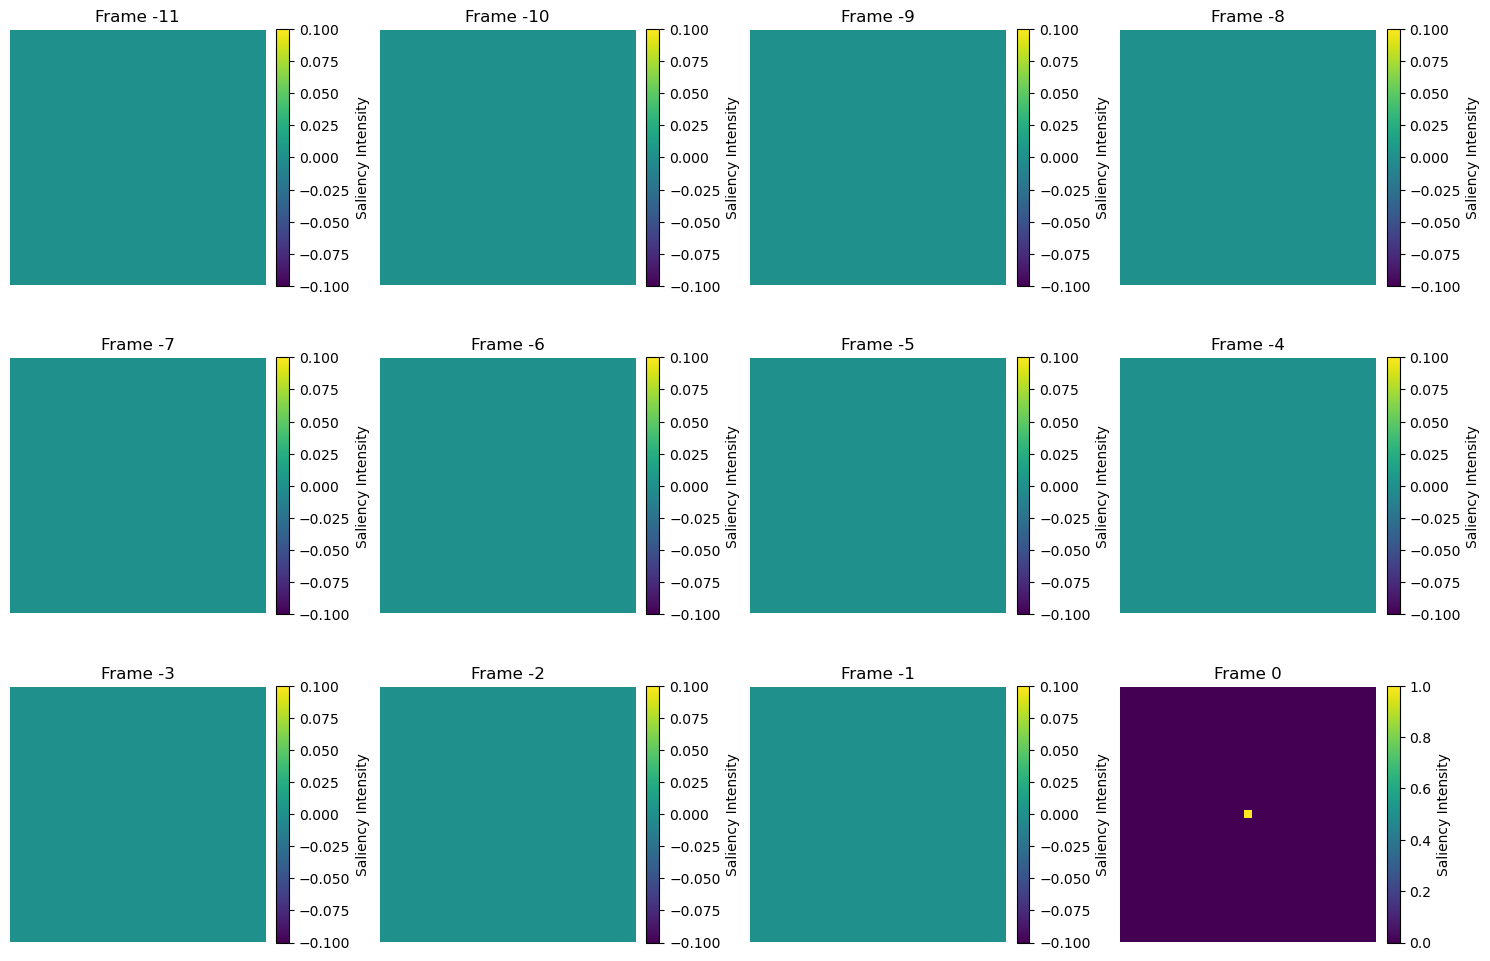

In [99]:
plot_maps(inputs, 'inputs', normalize=False)

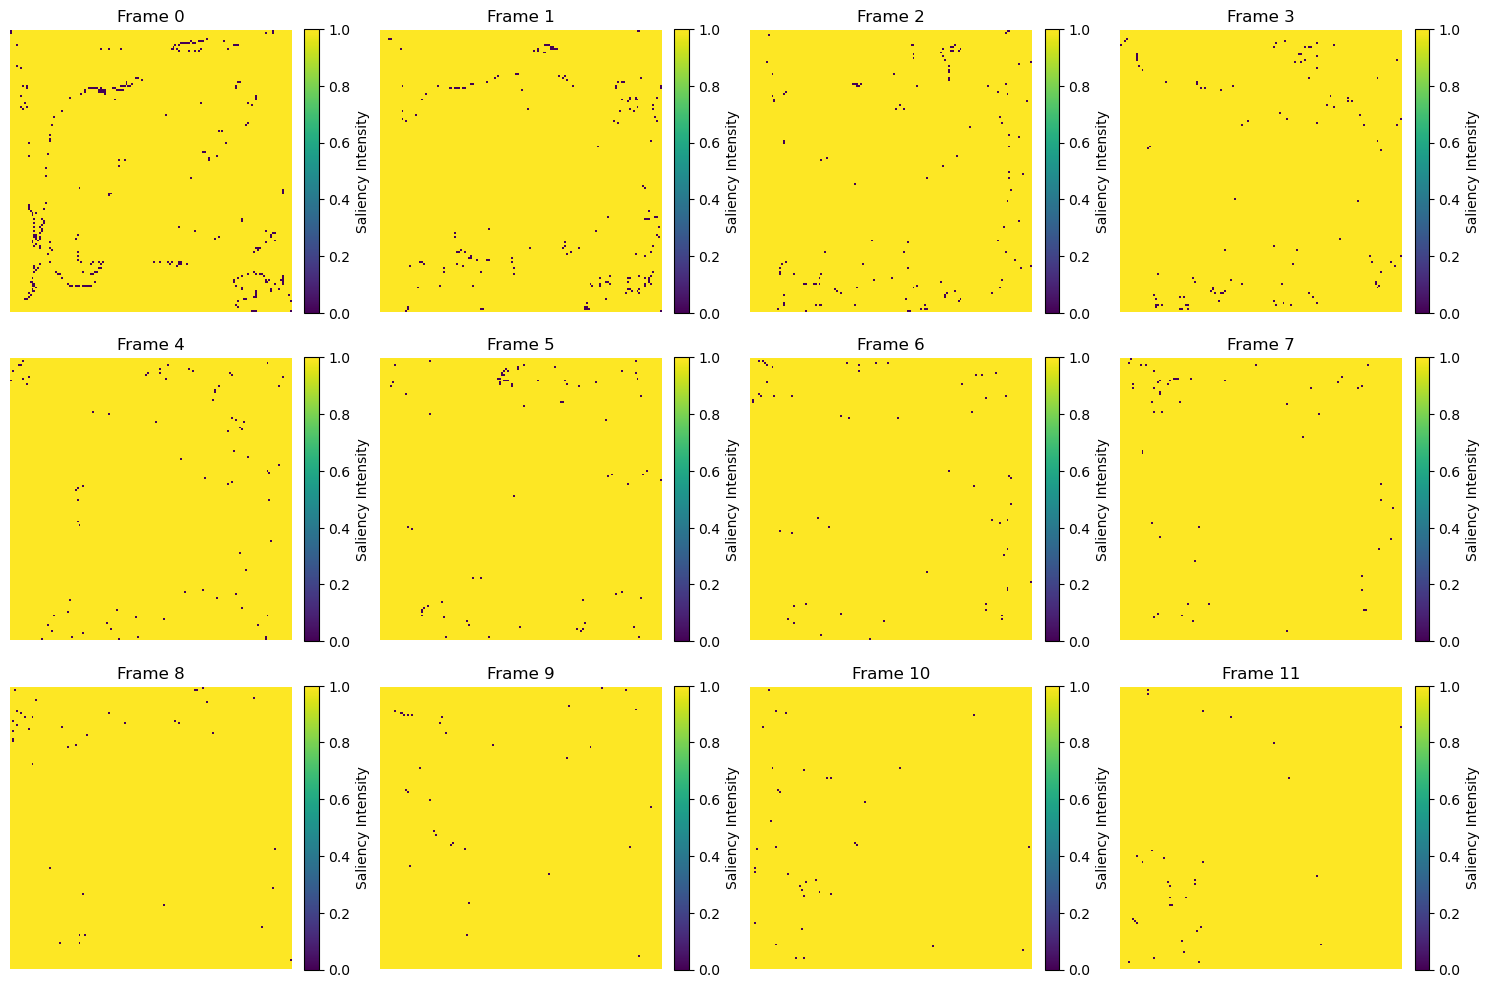

In [100]:
plot_maps(receptive_field, normalize=False)